# Description
I will use several deep learning models for my time series predictions. 
* LSTM
* Transformer
* dialated CNN

In all cases I will include daily snowfall as an exogenous variable.

## Environment
For $ reasons I will use Colab

In [1]:
# get colab status
try:
    import google.colab
    IN_COLAB = True
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [2]:
# data wrangling
import numpy as np
import pandas as pd
import os.path

# viz
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline
from vapeplot import vapeplot
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

In [31]:
# local code with hack to avoid cloing full repo each time colab is run
if IN_COLAB:
    projectcode = r"https://github.com/chrisoyer/ski-snow-modeling/blob/master/src/analysis/project_utils/project_utils.py"
    ! wget $projectcode
from project_utils.project_utils import *

In [4]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import RootMeanSquaredError as rmse
from tensorflow.keras.callbacks import EarlyStopping

# Parameters

In [32]:
alt.renderers.enable(embed_options={'theme': 'vox'})
alt.data_transformers.disable_max_rows()
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rc('figure', figsize=(11.0, 7.0))
batch_size = 15
logs_path = "./logs/visualize_graph"
lookback = 30  # days prior to use for prediction

# Plotting Functions

In [6]:
# todo: fix function in util to work for SM or TF
def y_and_yhat_plotter(model=None, data=None, test_data=None, steps=5, 
                       start_skip=1, include_interval=True):
    """plots values and model predictions
    Inputs:
        model: a fitted model with predict method
        data: df with time series data and pseudo_ts index
        test_data: out of sample data
        exog_col: column name
        steps: steps out to predict
        include_interval: bool if include prediction confidence interval"""
    # copy for both plots
    model_multi = model
    df = multi_df = data.rename(columns={'base': 'y'})
    test_df = test_multi_df = test_data.rename(columns={'base': 'y'})
    
    #get prediction for both train & test
    df = np.concatenate([df, test_df], axis=0)
    #check model type TF vs SM

    modelkwgs = multikwgs = {}
    df['yhat'] = model.predict(df)
    if include_interval:
        df['lowerCI'] = model.prediction_ci.iloc[:, 0]
        df['upperCI'] = model.prediction_ci.iloc[:, 1]
    test_multi_df['yhat'] = model_multi.predict(test_multi_df, **multikwgs)
    if include_interval:
        test_multi_df['lowerCI'] = model_multi.prediction_ci.iloc[:, 0]
        test_multi_df['upperCI'] = model_multi.prediction_ci.iloc[:, 1]
    
    multi_df = pd.concat([multi_df, test_multi_df])

    # skip first value: predictions are based on prior values
    df2, multi2_df = df.iloc[start_skip:, :], multi_df.iloc[start_skip:, :]

    def melt_predicts(df):
        return (df
                .reset_index()
                .rename(columns={'index': 'pseudo_ts'})
                .melt(value_vars=['y', 'yhat'], id_vars=['pseudo_ts'])
                )
    melted_df2 = melt_predicts(df)
    melted_df_multi2 = melt_predicts(multi_df)

    fig, axes = plt.subplots(2, 1, figsize=(18, 6), sharex=True)

    def plot_sub(y, ci_data, axis):
        sns.lineplot(data=y, x='pseudo_ts', y='value', hue='variable',
                     marker='x', ax=axis)
        if include_interval:
            axis.fill_between(ci_data.index, ci_data.lowerCI,
                              ci_data.upperCI, alpha=.3)
    data = (df2, multi2_df)
    melted_data = (melted_df2, melted_df_multi2)
    for datum, melted_datum, axis in zip(data, melted_data, axes):
        plot_sub(y=melted_datum, ci_data=datum, axis=axis)
    axes[0].set_title("One Step Prediction over Train & Test")
    axes[1].set_title("Recursive Prediction on Test Set")

# Load Data

In [7]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir(r'/content/gdrive/My Drive/data_sci/colab_datasets/ski/')
    all_data_path = r'./data/snow_data_clean.parquet'
    mirrored_strategy = tf.distribute.MirroredStrategy()
else:
    all_data_path = r'../../data/snow_data_clean.parquet'
!pwd

/c/Users/User/Documents/GitHub/ski-snow-modeling/src/analysis


In [8]:
snow_df = pd.read_parquet(all_data_path)

### Reshape for TF input
Shape should match (__samples__, __time steps__, __features__)

In [9]:
def data_slim(source=snow_df, station=None, region=None):
    """filters data for station OR region, relevant features, and returns np"""
    if station:
        source = source.query('station==@station')
    if region:
        source = source.query('region==@region')

    data_arr = (source
                .reset_index()
                [['base', 'dayofyr', 'snowfall']]
                .to_numpy()
                )
    return data_arr

In [10]:
# scale data
def scaler(X):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(X)
    scaled_X = scaler.transform(X)

    # invert transform
    inverted_X = scaler.inverse_transform(scaled_X)
    return scaled_X, scaler

In [11]:
copper = data_slim(station="Copper Mountain")

copper_scaled, copper_scaler = scaler(copper)

In [12]:
def data_split(data=None, test_frac=.2, lookback=lookback, 
               batch_size=batch_size, return_dfs=False):
    """split into train and test sets
    Params:
        data: endogenous should be first col
        test_frac: fraction of data for test
        lookback: prior time units to use for generating prediction
        return_dfs: set to True to return dataframes (for plotting) instead of
                    data generators
    returns: (training, test) data generator or dfs
    """
    data_rows = data.shape[0]
    test_size = int(data_rows * test_frac)
    train_size = data_rows - test_size
    train, test = data[:train_size, :], data[train_size:, :]
    if return_dfs:
        return (pd.DataFrame(train).rename(columns={0:"base", 1:'dayofyr', 2:'snowfall'}), 
                pd.DataFrame(test).rename(columns={0:"base", 1:'dayofyr', 2:'snowfall'}))
    gen_params = {'length': lookback,  # prior samples used for prediction
                  'sampling_rate': 1, 'stride': 1,
                  'batch_size': batch_size}
    train_data_gen = sequence.TimeseriesGenerator(data=train,
                                                  targets=train[:, 0],
                                                  **gen_params)
    test_data_gen = sequence.TimeseriesGenerator(data=test,
                                                 targets=test[:, 0],
                                                 **gen_params)
    return train_data_gen, test_data_gen


Xy_train, Xy_val = data_split(data=copper_scaled)

# Timeseries Modeling

The evolution of snow base depth over time depends (not 1:1; a foot of powder is only a few inches of packed powder) on new snowfall and melting of old snow. I will start by modeling as a simple timeseries, and then include new snowfall as a predictor variable.

## Modeling Setup
I will use supersetting crossvalidation (walk-forward CV) since this is a time series problem.

# TF LSTM models
 

In [13]:
def make_lstm(neurons=None, layers=None, batch_size=None, x_shape=None, lookback=lookback):
    """
    Parameters:
        neurons: width of layers, eg (4,5,6) implies first hidden layer has 4
            neuron, 2nd layer has 5, third layer has 6
        batch size: ...
        x_shape: (rows, features)
    Returns: unfitted model
    """
    input_shape = (lookback, x_shape[1])
    xlayer = inputs = Input(shape=input_shape, batch_size=batch_size)
    lstm_kwargs = dict(units=neurons, batch_input_shape=input_shape,
                           stateful=True, dropout=0.2, recurrent_dropout=0.2,
                           return_sequences=False)
    for layer in range(layers):
        lstm_kwargs['return_sequences'] = False if layer == layers-1 else True
        xlayer = LSTM(**lstm_kwargs)(xlayer)
    outputs = Dense(1)(xlayer)
    model = Model(inputs=inputs, outputs=outputs)
    metrics = ['mean_absolute_error', 'mean_squared_error']
    model.compile(loss="mse", metrics=metrics,
                  optimizer='adam')
    return model


def fit_model(model, X, X_val, batch_size, n_epoch):
    """runs the training; returns model and history"""
    cb = EarlyStopping(monitor='mean_squared_error', patience=3, restore_best_weights=True)
    history = model.fit(X, validation_data=X_val,
                        epochs=n_epoch, batch_size=batch_size,
                        shuffle=False, callbacks=[cb],
                        verbose=1)
    return model, history

# Vanilla LSTM Model

In [14]:
model_kwg = {'batch_size': batch_size, 'x_shape': copper_scaled.shape,}
modelfit_kwg = {'X': Xy_train, 'X_val': Xy_val, 
                'batch_size': batch_size, 
               'n_epoch': 25}

### 1 layer

In [15]:
lstm_100x1 = make_lstm(neurons=100, layers=1, **model_kwg)
lstm_100x1, lstm_100x1_hst = fit_model(model=lstm_100x1, 
                                       **modelfit_kwg)
lstm_100x1.summary()

Epoch 1/25
154/154 [==============================] - 6s 37ms/step - loss: 0.0594 - mean_absolute_error: 0.1981 - mean_squared_error: 0.0594 - val_loss: 0.0147 - val_mean_absolute_error: 0.1001 - val_mean_squared_error: 0.0147
Epoch 2/25
154/154 [==============================] - 6s 37ms/step - loss: 0.0187 - mean_absolute_error: 0.1078 - mean_squared_error: 0.0187 - val_loss: 0.0084 - val_mean_absolute_error: 0.0682 - val_mean_squared_error: 0.0084
Epoch 3/25
154/154 [==============================] - 5s 35ms/step - loss: 0.0156 - mean_absolute_error: 0.0977 - mean_squared_error: 0.0156 - val_loss: 0.0122 - val_mean_absolute_error: 0.0867 - val_mean_squared_error: 0.0122 2s - l
Epoch 4/25
154/154 [==============================] - 6s 40ms/step - loss: 0.0114 - mean_absolute_error: 0.0832 - mean_squared_error: 0.0114 - val_loss: 0.0054 - val_mean_absolute_error: 0.0527 - val_mean_squared_error: 0.0054
Epoch 5/25
154/154 [==============================] - 6s 42ms/step - loss: 0.0100 - m

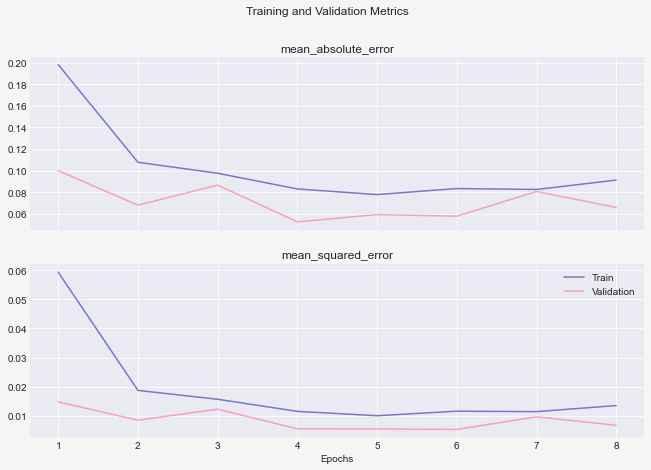

In [16]:
hist_plotter(lstm_100x1_hst.history)

### 2 Layers

In [17]:
lstm_100x2 = make_lstm(neurons=100, layers=2,**model_kwg)
lstm_100x2, lstm_100x2_hst = fit_model(model=lstm_100x2, **modelfit_kwg)
lstm_100x2.summary()

Epoch 1/25
154/154 [==============================] - 16s 102ms/step - loss: 0.0621 - mean_absolute_error: 0.1920 - mean_squared_error: 0.0621 - val_loss: 0.0068 - val_mean_absolute_error: 0.0620 - val_mean_squared_error: 0.0068
Epoch 2/25
154/154 [==============================] - 14s 92ms/step - loss: 0.0236 - mean_absolute_error: 0.1182 - mean_squared_error: 0.0236 - val_loss: 0.0163 - val_mean_absolute_error: 0.0981 - val_mean_squared_error: 0.0163
Epoch 3/25
154/154 [==============================] - 14s 91ms/step - loss: 0.0206 - mean_absolute_error: 0.1104 - mean_squared_error: 0.0206 - val_loss: 0.0083 - val_mean_absolute_error: 0.0727 - val_mean_squared_error: 0.0083
Epoch 4/25
154/154 [==============================] - 14s 94ms/step - loss: 0.0169 - mean_absolute_error: 0.1014 - mean_squared_error: 0.0169 - val_loss: 0.0096 - val_mean_absolute_error: 0.0787 - val_mean_squared_error: 0.0096
Epoch 5/25
154/154 [==============================] - 14s 93ms/step - loss: 0.0217 - me

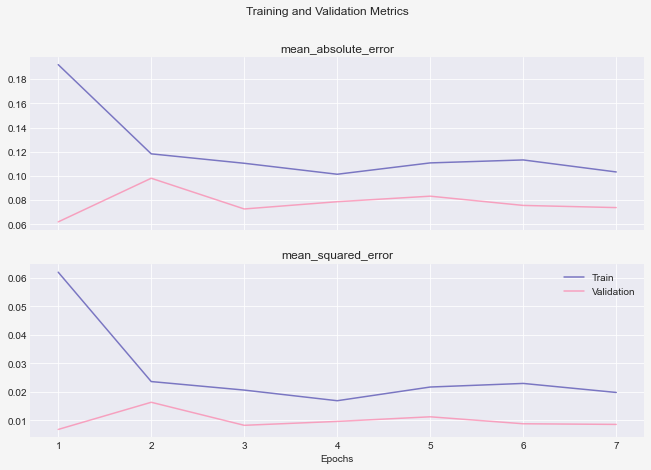

In [18]:
hist_plotter(lstm_100x2_hst.history)

### 1 Layer, 250 Cells

In [19]:
lstm_250x1 = make_lstm(neurons=250, layers=1,**model_kwg)
lstm_250x1, lstm_250x1_hst = fit_model(model=lstm_250x1, **modelfit_kwg)
lstm_250x1.summary()

Epoch 1/25
154/154 [==============================] - 25s 162ms/step - loss: 0.0626 - mean_absolute_error: 0.1962 - mean_squared_error: 0.0626 - val_loss: 0.0055 - val_mean_absolute_error: 0.0581 - val_mean_squared_error: 0.0055
Epoch 2/25
154/154 [==============================] - 24s 154ms/step - loss: 0.0269 - mean_absolute_error: 0.1230 - mean_squared_error: 0.0269 - val_loss: 0.0113 - val_mean_absolute_error: 0.0826 - val_mean_squared_error: 0.0113
Epoch 3/25
154/154 [==============================] - 24s 153ms/step - loss: 0.0235 - mean_absolute_error: 0.1189 - mean_squared_error: 0.0235 - val_loss: 0.0482 - val_mean_absolute_error: 0.1829 - val_mean_squared_error: 0.0482
Epoch 4/25
154/154 [==============================] - 24s 159ms/step - loss: 0.0220 - mean_absolute_error: 0.1133 - mean_squared_error: 0.0220 - val_loss: 0.0283 - val_mean_absolute_error: 0.1275 - val_mean_squared_error: 0.0283
Epoch 5/25
154/154 [==============================] - 24s 154ms/step - loss: 0.0173 

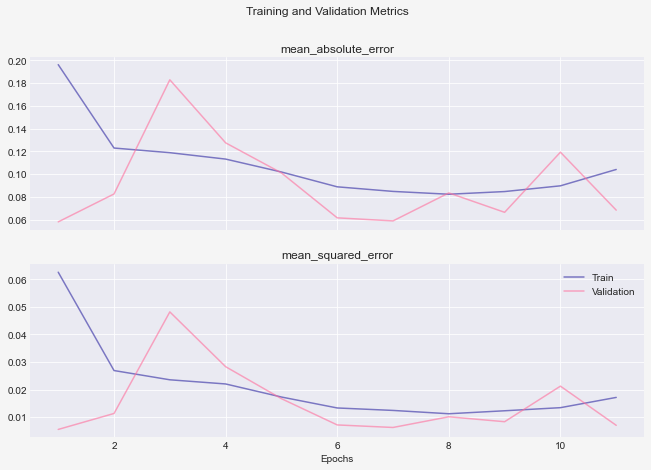

In [20]:
hist_plotter(lstm_250x1_hst.history)

### 1 Layer, 400 Cells
I want to be sure to try cell count<days per year

In [21]:
lstm_400x1 = make_lstm(neurons=400, layers=1,**model_kwg)
lstm_400x1, lstm_400x1_hst = fit_model(model=lstm_400x1, **modelfit_kwg)
lstm_400x1.summary()

Epoch 1/25
154/154 [==============================] - 63s 408ms/step - loss: 0.0652 - mean_absolute_error: 0.2052 - mean_squared_error: 0.0652 - val_loss: 0.0494 - val_mean_absolute_error: 0.1958 - val_mean_squared_error: 0.0494
Epoch 2/25
154/154 [==============================] - 61s 393ms/step - loss: 0.0295 - mean_absolute_error: 0.1322 - mean_squared_error: 0.0295 - val_loss: 0.0247 - val_mean_absolute_error: 0.1297 - val_mean_squared_error: 0.0247
Epoch 3/25
154/154 [==============================] - 61s 398ms/step - loss: 0.0260 - mean_absolute_error: 0.1228 - mean_squared_error: 0.0260 - val_loss: 0.0390 - val_mean_absolute_error: 0.1724 - val_mean_squared_error: 0.0390
Epoch 4/25
154/154 [==============================] - 62s 401ms/step - loss: 0.0224 - mean_absolute_error: 0.1124 - mean_squared_error: 0.0224 - val_loss: 0.0072 - val_mean_absolute_error: 0.0621 - val_mean_squared_error: 0.0072
Epoch 5/25
154/154 [==============================] - 61s 396ms/step - loss: 0.0165 

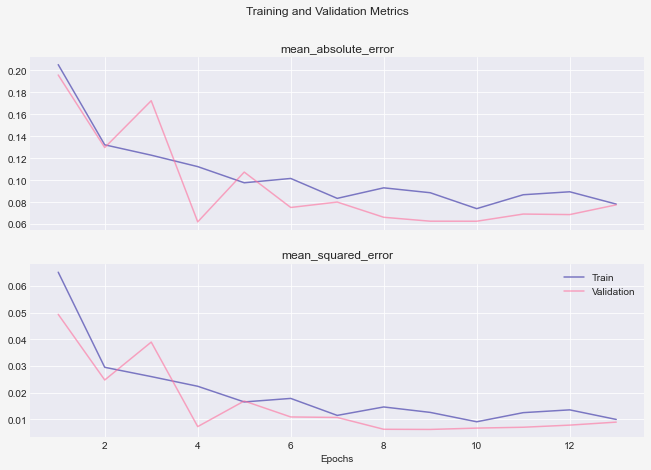

In [35]:
hist_plotter(lstm_400x1_hst.history)

# Compare Models

In [23]:
# get non-generator version of data for prediction and plottings
train_df, test_df = data_split(data=copper_scaled, return_dfs=True)
train_df.tail()

,base,dayofyr,snowfall
2335,-0.037337,-0.160976,-1.000000
2336,0.008953,-0.156098,-1.000000
2337,0.008953,-0.151220,-0.894737
2338,0.008953,-0.146341,-1.000000
2339,0.008953,-0.141463,-0.578947


In [24]:
def unscale_predictions(y, scaler):
    predictions_scaled_padded = np.zeros(shape=(y.shape[0], 3))
    y_len = y.shape[0]
    predictions_scaled_padded[:, 0] = y[:y_len,0]
    return scaler.inverse_transform(predictions_scaled_padded)[:, 0]

def get_predictions(model, data, lookback):
    yhat = model.predict(data)
    pad = np.zeros(shape=(lookback, 1))
    pad[:] = np.NaN 
    return np.concatenate([pad, yhat])

In [25]:
# get unscaled series for y
copper_unscaled_val = unscale_predictions(test_df.base.to_numpy().reshape(-1,1),
                                          copper_scaler)

# get yhat series
copper_predictions_scaled250 = get_predictions(lstm_250x1, Xy_val, lookback)
copper_predictions250 = unscale_predictions(y=copper_predictions_scaled250, scaler=copper_scaler)

copper_predictions_scaled400 = get_predictions(lstm_400x1, Xy_val, lookback)
copper_predictions400 = unscale_predictions(y=copper_predictions_scaled400, scaler=copper_scaler)

In [33]:
def yhat_plotter_df(y=copper_unscaled_val, yhat=None, title=None):
    fig, ax = plt.subplots()
    plt.plot(yhat, label="y hat")
    plt.plot(y, label="y")
    fig.legend(loc='right', prop={'size': 15}, frameon=True)
    ax.set_title(title, size=25);

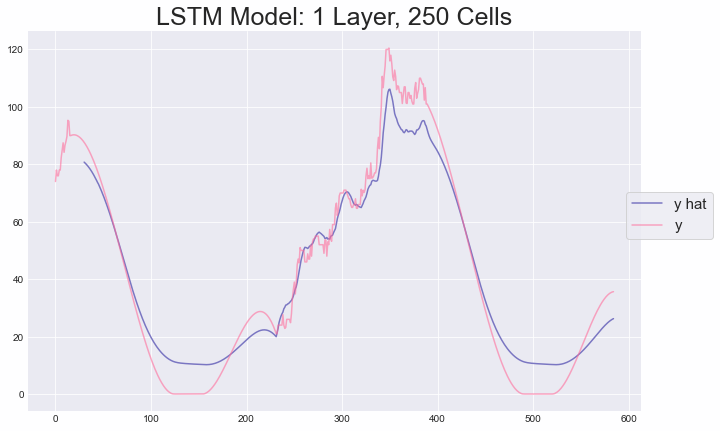

In [29]:
yhat_plotter_df(yhat=copper_predictions250, title="LSTM Model: 1 Layer, 250 Cells")

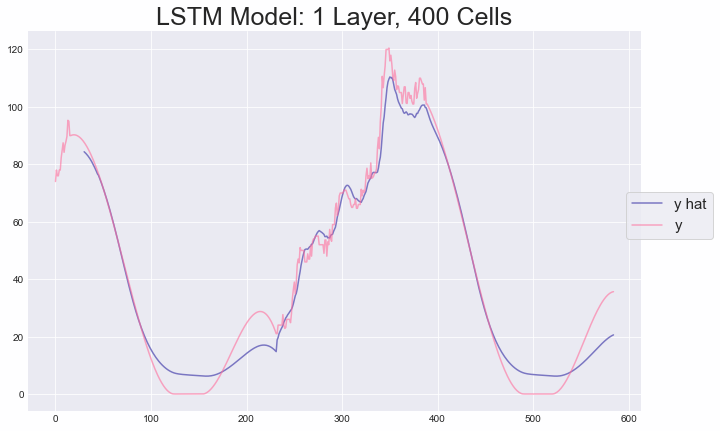

In [34]:
yhat_plotter_df(yhat=copper_predictions400, title="LSTM Model: 1 Layer, 400 Cells")

this matches the true series quite well, and the main exception is in the region of the data where the data was missing and had to be interpolated. At this point, using a better model for that interpolating that region would be necessary, but that is getting beyond what I have data for.